In [3]:
import os
os.chdir('C:\\Users\\91898\\mlenv')

In [4]:
os.getcwd()

'C:\\Users\\91898\\mlenv'

__Hardcodded

Extracted Angle: 90°
90° Gait Cycle Detected: Frame 5 to 40
Frame ignoring factor: 0.1


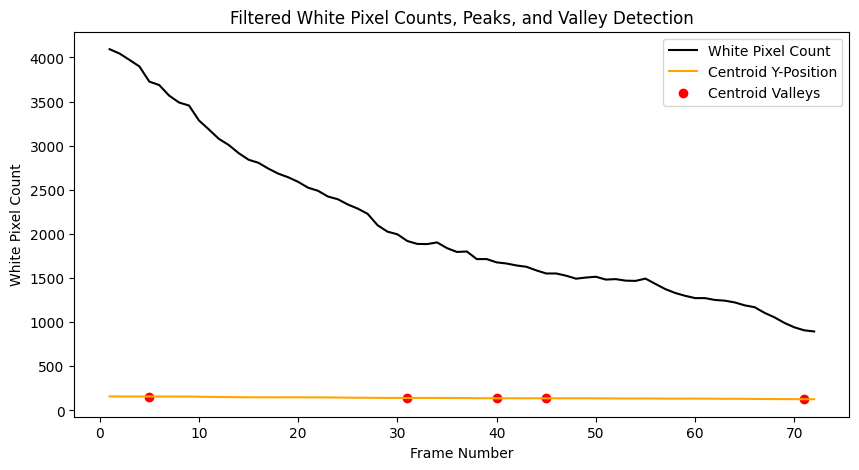

In [60]:
from scipy.signal import argrelextrema
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Folder paths
silhouette_folder = os.path.join("CASIA-a", "GaitDatasetA-silh", "GaitDatasetA-silh", "fyc", "90_3")
white_pixel_threshold = 150 # Minimum white pixel count for a frame to be considered

# Extract the folder name (last part of the path)
folder_name = os.path.basename(silhouette_folder)
# Extract angle from folder name
angle = folder_name.split('_')[0]  # Get the first part before '_'
# Convert to integer
angle = int(angle)
print(f"Extracted Angle: {angle}°")
frame_ignoring_factor=0.1
if(angle==45):
    frame_ignoring_factor=0.25

# Function to count white pixels in the lower half of the image
def count_white_pixels_lower_half(img):
    height, width = img.shape
    if angle == 45:
        lower_half = img[(height//2)+16:, :]  # Extract the lower half
    else:
        lower_half = img[(height//2):, :]
    return np.count_nonzero(lower_half)


# Function to compute centroid of the silhouette
def compute_centroid(img):
    y_indices, x_indices = np.where(img > 0)  # Find all white pixel positions
    if len(y_indices) == 0:  # No silhouette detected
        return None
    centroid_y = np.mean(y_indices)
    return centroid_y

# Read all frame files
image_files = sorted(os.listdir(silhouette_folder))

if angle == 90:
    # Determine if white pixel count is increasing or decreasing
    white_pixel_counts_temp = []
    for img_file in image_files:
        frame_path = os.path.join(silhouette_folder, img_file)
        img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        white_pixel_counts_temp.append(count_white_pixels_lower_half(img))
    
    if white_pixel_counts_temp[0] < white_pixel_counts_temp[-1]:
        # Increasing trend, ignore first 25%
        ignore_count = int(0.25 * len(image_files))
        image_files = image_files[ignore_count:]
    else:
        # Decreasing trend, ignore last 25%
        ignore_count = int(0.25 * len(image_files))
        image_files = image_files[:-ignore_count]
else:
    # Ignore first 25% of frames for other angles
    ignore_count = int(0.25 * len(image_files))
    image_files = image_files[ignore_count:]


# Extract white pixel count for each frame
frame_pixel_counts = []
frame_numbers = []
centroid_positions = []


for img_file in image_files:
    frame_path = os.path.join(silhouette_folder, img_file)
    img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    
    frame_number = int(os.path.splitext(img_file)[0].split('-')[-1])  # Extract numeric frame number
    white_pixel_count = count_white_pixels_lower_half(img)
    if angle==90:
            centroid_y = compute_centroid(img)


    if white_pixel_count >= white_pixel_threshold:  # Only keep significant frames
        frame_pixel_counts.append(white_pixel_count)
        frame_numbers.append(frame_number)
        if angle ==90:
            centroid_positions.append(centroid_y)


frame_pixel_counts_np = np.array(frame_pixel_counts)
if angle ==90:
    centroid_positions_np = np.array(centroid_positions)
    # **90-degree case: Centroid Tracking Method**
    # Detect valleys (local minima) in centroid y-coordinates
    valley_indices = argrelextrema(centroid_positions_np, np.less, order=3)[0]
    valley_frames = [frame_numbers[i] for i in valley_indices]
    # Use first and third valley as gait cycle
    if len(valley_frames) >= 3:
        first_valley_frame = valley_frames[0]
        third_valley_frame = valley_frames[2]
        print(f"90° Gait Cycle Detected: Frame {first_valley_frame} to {third_valley_frame}")
    else:
        print("Not enough valleys detected for gait cycle.")
        first_valley_frame, third_valley_frame = None, None

else:
    # Compute max pixel count and set a threshold
    max_pixel_count = np.max(frame_pixel_counts_np)
    pixel_count_threshold = 0.2 * max_pixel_count  # 20% of max pixel count

    # Ignore peaks/valleys below this threshold
    valid_indices = [i for i in range(len(frame_pixel_counts)) if frame_pixel_counts[i] > pixel_count_threshold]

    # Detect **peaks** (local maxima)
    peak_indices = argrelextrema(frame_pixel_counts_np, np.greater, order=3)[0]
    peak_indices = [i for i in peak_indices if i in valid_indices]  # Filter peaks

    # Detect **valleys** (local minima)
    valley_indices = argrelextrema(frame_pixel_counts_np, np.less, order=3)[0]
    valley_indices = [i for i in valley_indices if i in valid_indices]  # Filter valleys


    # Convert indices to actual frame numbers
    peak_frames = [frame_numbers[i] for i in peak_indices]
    valley_frames = [frame_numbers[i] for i in valley_indices]

    # Two-pointer approach to remove peak-valley pairs with less than 4-frame difference
    filtered_peak_frames = []
    filtered_valley_frames = []

    p, v = 0, 0  # Initialize peak and valley pointers

    while p < len(peak_frames) and v < len(valley_frames):
        peak = peak_frames[p]
        valley = valley_frames[v]

        if peak - valley >= 4:
            filtered_peak_frames.append(peak)
            filtered_valley_frames.append(valley)
            p += 1
            v += 1  # Move both pointers forward
        else:
            # Remove the closer peak-valley pair
            if peak < valley:
                p += 1  # Skip peak
            else:
                v += 1  # Skip valley

    # Update the lists with filtered peaks and valleys
    peak_frames = filtered_peak_frames
    valley_frames = filtered_valley_frames

    # **Step 1: Remove False Start & End Valleys**
    buffer_size = max(2, int(len(frame_pixel_counts) * frame_ignoring_factor))  # Ignore first & last 10% of frames
    filtered_valley_frames = [v for v in valley_frames if frame_numbers.index(v) > buffer_size and frame_numbers.index(v) < len(frame_pixel_counts) - buffer_size]

    # **Step 2: Select First and Third Valid Valley as Gait Cycle**
    if len(filtered_valley_frames) >= 3:
        first_valley_frame = filtered_valley_frames[0]
        third_valley_frame = filtered_valley_frames[2]
        print(f"Initial Gait Cycle: Frame {first_valley_frame} to {third_valley_frame}")
    else:
        print(" Not enough valid valleys detected to determine a gait cycle.")
        first_valley_frame, third_valley_frame = None, None
    
# **Step 4: Plot Results**
plt.figure(figsize=(10, 5))
plt.plot(frame_numbers, frame_pixel_counts, label="White Pixel Count", color='black')

if angle ==90:
    # Plot centroid movements
    plt.plot(frame_numbers, centroid_positions, label="Centroid Y-Position", color='orange')
    plt.scatter(valley_frames, [centroid_positions[frame_numbers.index(f)] for f in valley_frames], color='red', label="Centroid Valleys")

else:
    # Mark peaks
    plt.scatter(peak_frames, [frame_pixel_counts[frame_numbers.index(f)] for f in peak_frames], 
                color='green', label="Detected Peaks")

    # Mark filtered valleys
    plt.scatter(filtered_valley_frames, [frame_pixel_counts[frame_numbers.index(f)] for f in filtered_valley_frames], 
                color='red', label="Filtered Valleys")

    # Mark first and third valley if they exist
    if first_valley_frame and third_valley_frame:
        plt.axvline(x=first_valley_frame, color='blue', linestyle='--', label=f"Start: {first_valley_frame}")
        plt.axvline(x=third_valley_frame, color='purple', linestyle='--', label=f"End: {third_valley_frame}")

print(f"Frame ignoring factor: {frame_ignoring_factor}")
# Plot styling
plt.xlabel("Frame Number")
plt.ylabel("White Pixel Count")
plt.title("Filtered White Pixel Counts, Peaks, and Valley Detection")
plt.legend()
plt.show()


Extracted Angle: 90°
90° Gait Cycle Detected: Frame 51 to (None, None)


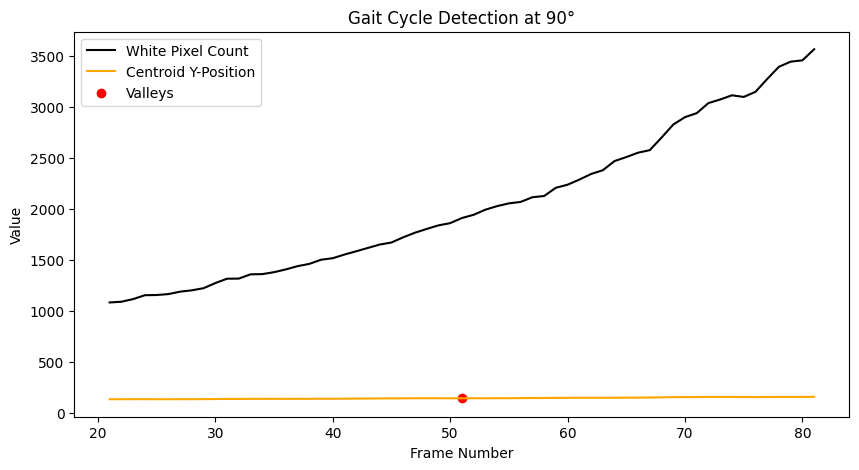

TypeError: 'tuple' object cannot be interpreted as an integer

In [75]:
import numpy as np
import cv2
import os
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import torch

# Configuration
silhouette_folder = os.path.join("CASIA-a", "GaitDatasetA-silh", "GaitDatasetA-silh", "fyc", "90_3")
white_pixel_threshold = 150  # Minimum white pixel count
ANGLE_CONFIG = {
    90: {"ignore_factor": 0.25, "method": "centroid", "crop_offset": 0},
    45: {"ignore_factor": 0.25, "method": "pixel_count", "crop_offset": 16},
    0: {"ignore_factor": 0.1, "method": "pixel_count", "crop_offset": 0}  # Assuming 0° as default
}

# Extract angle from folder name
angle = int(os.path.basename(silhouette_folder).split('_')[0])
print(f"Extracted Angle: {angle}°")
config = ANGLE_CONFIG.get(angle, ANGLE_CONFIG[0])  # Default to 0° if angle not found

# Utility Functions
def count_white_pixels_lower_half(img, offset):
    """Count white pixels in the lower half of the image with optional offset."""
    h = img.shape[0]
    lower_half = img[(h // 2) + offset:, :]
    return np.count_nonzero(lower_half)

def compute_centroid(img):
    """Compute Y-centroid of the silhouette."""
    y_indices, _ = np.where(img > 0)
    return np.mean(y_indices) if y_indices.size > 0 else np.nan

def load_and_process_frames(folder, threshold, config):
    """Load frames and compute features efficiently."""
    image_files = sorted(os.listdir(folder))
    pixel_counts = []
    centroids = []
    frame_numbers = []

    # Precompute trend for 90° (optional single pass)
    if config["method"] == "centroid":
        temp_counts = [
            count_white_pixels_lower_half(cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE), config["crop_offset"])
            for f in image_files
        ]
        trend = "increasing" if temp_counts[0] < temp_counts[-1] else "decreasing"
        ignore_count = int(config["ignore_factor"] * len(image_files))
        image_files = image_files[ignore_count:] if trend == "increasing" else image_files[:-ignore_count]
    else:
        ignore_count = int(config["ignore_factor"] * len(image_files))
        image_files = image_files[ignore_count:]

    # Single-pass processing
    for img_file in image_files:
        frame_path = os.path.join(folder, img_file)
        img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        frame_number = int(os.path.splitext(img_file)[0].split('-')[-1])
        pixel_count = count_white_pixels_lower_half(img, config["crop_offset"])
        if pixel_count < threshold:
            continue

        frame_numbers.append(frame_number)
        pixel_counts.append(pixel_count)
        if config["method"] == "centroid":
            centroids.append(compute_centroid(img))

    return np.array(frame_numbers), np.array(pixel_counts), np.array(centroids) if centroids else None

# Process frames
frame_numbers, pixel_counts, centroids = load_and_process_frames(silhouette_folder, white_pixel_threshold, config)
if len(frame_numbers) < 5:  # Minimum frames for meaningful detection
    print("Error: Too few valid frames detected.")
    exit()

# Gait Cycle Detection
def detect_gait_cycle(frame_numbers, signal, method, min_distance=3):
    """Detect gait cycle using peaks or valleys."""
    smoothed = np.convolve(signal, np.ones(5)/5, mode='valid')  # Smooth signal
    pad = (len(signal) - len(smoothed)) // 2
    indices = frame_numbers[pad:len(smoothed) + pad]  # Align with smoothed signal

    if method == "centroid":
        valley_indices = argrelextrema(smoothed, np.less, order=min_distance)[0]
        valley_frames = indices[valley_indices]
        return valley_frames[0], valley_frames[2] if len(valley_frames) >= 3 else (None, None)
    else:
        max_count = np.max(smoothed)
        threshold = 0.2 * max_count
        valid_mask = smoothed > threshold

        peak_indices = argrelextrema(smoothed, np.greater, order=min_distance)[0]
        valley_indices = argrelextrema(smoothed, np.less, order=min_distance)[0]
        peaks = indices[peak_indices][np.where(valid_mask[peak_indices])]
        valleys = indices[valley_indices][np.where(valid_mask[valley_indices])]

        # Filter peak-valley pairs
        filtered_peaks, filtered_valleys = [], []
        p, v = 0, 0
        while p < len(peaks) and v < len(valleys):
            if abs(peaks[p] - valleys[v]) >= 4:
                filtered_peaks.append(peaks[p])
                filtered_valleys.append(valleys[v])
                p += 1
                v += 1
            elif peaks[p] < valleys[v]:
                p += 1
            else:
                v += 1

        buffer = max(2, int(len(frame_numbers) * config["ignore_factor"]))
        filtered_valleys = [v for v in filtered_valleys if buffer < frame_numbers.tolist().index(v) < len(frame_numbers) - buffer]
        return filtered_valleys[0], filtered_valleys[2] if len(filtered_valleys) >= 3 else (None, None)

# Detect cycle
signal = centroids if config["method"] == "centroid" else pixel_counts
first_valley, third_valley = detect_gait_cycle(frame_numbers, signal, config["method"])
if first_valley and third_valley:
    print(f"{angle}° Gait Cycle Detected: Frame {first_valley} to {third_valley}")
else:
    print("Not enough valid points for gait cycle.")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(frame_numbers, pixel_counts, label="White Pixel Count", color='black')
if config["method"] == "centroid":
    plt.plot(frame_numbers, centroids, label="Centroid Y-Position", color='orange')
    valleys = [f for f in frame_numbers if f in detect_gait_cycle(frame_numbers, centroids, "centroid")[::2]]
    plt.scatter(valleys, centroids[[frame_numbers.tolist().index(v) for v in valleys]], color='red', label="Valleys")
else:
    peaks, valleys = [], []
    smoothed = np.convolve(pixel_counts, np.ones(5)/5, mode='valid')
    pad = (len(pixel_counts) - len(smoothed)) // 2
    indices = frame_numbers[pad:len(smoothed) + pad]
    peak_idx = argrelextrema(smoothed, np.greater, order=3)[0]
    valley_idx = argrelextrema(smoothed, np.less, order=3)[0]
    peaks = indices[peak_idx]
    valleys = [v for v in indices[valley_idx] if v in detect_gait_cycle(frame_numbers, pixel_counts, "pixel_count")[::2]]
    plt.scatter(peaks, [pixel_counts[frame_numbers.tolist().index(p)] for p in peaks], color='green', label="Peaks")
    plt.scatter(valleys, [pixel_counts[frame_numbers.tolist().index(v)] for v in valleys], color='red', label="Valleys")
    if first_valley and third_valley:
        plt.axvline(x=first_valley, color='blue', linestyle='--', label=f"Start: {first_valley}")
        plt.axvline(x=third_valley, color='purple', linestyle='--', label=f"End: {third_valley}")

plt.xlabel("Frame Number")
plt.ylabel("Value")
plt.title(f"Gait Cycle Detection at {angle}°")
plt.legend()
plt.show()

# PyTorch Tensor Output (for downstream use)
frame_tensor = torch.LongTensor(frame_numbers)
signal_tensor = torch.FloatTensor(centroids if config["method"] == "centroid" else pixel_counts)
cycle_tensor = torch.LongTensor([first_valley, third_valley]) if first_valley and third_valley else None